> And the whole question of reinforcement learning is how can we get this ultimate reward that we will get and propagate it back and learned how to behave.                            
--MITx_6.86x

# 前言

## 强化学习基础篇

### 1. 初探强化学习

### 2. 多臂老虎机

#### 2.2. 问题介绍

实现一个拉杆数为 10 的多臂老虎机。其中拉动每根拉杆的奖励服从伯努利分布（Bernoulli distribution），即每次拉下拉杆有的概率获得的奖励为 1，有的概率获得的奖励为 0。奖励为 1 代表获奖，奖励为 0 代表没有获奖。

In [121]:
import matplotlib.pyplot as plt
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """

    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        if np.random.rand() < self.probs[k]:  ## 依概率self.probs[k]返回的奖励1
            return 1
        else:
            return 0  ## 依概率1 - self.probs[k]返回的奖励0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print(f'随机生成了一个{K}臂伯努利老虎机')
print(f'获奖概率最大的拉杆为{bandit_10_arm.best_idx}号,其获奖概率为{bandit_10_arm.best_prob:.4f}')

# 随机生成了一个10臂伯努利老虎机
# 获奖概率最大的拉杆为1号,其获奖概率为0.7203

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


用一个 Solver 基础类来实现上述的多臂老虎机的求解方案。

In [122]:
class Solver:
    """ 多臂老虎机算法基本框架 """

    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()  ## 根据策略选择拉杆，然后拉动拉杆，算拉杆奖励的期望值
            self.counts[k] += 1  ## 拉动拉杆的次数+1
            self.actions.append(k)  ## 记录每一步的动作action，也就是拉动的拉杆标号
            self.update_regret(k)  ## 更新懊悔地累加值

#### 2.3. Exploration and Exploitation

##### 2.3.1. Epsilon-Greedy

每次以概率 $\epsilon$ 选择随机动作，以概率 $1-\epsilon$ 选择当前最优动作。

estimates增量更新推导：
$$
\begin{align*}
Q_{n+1} &= \frac{1}{n+1} \sum_{i=1}^{n+1} r_{i} \\
     &= \frac{1}{n+1} (r_{n+1} + \sum_{i=1}^{n} r_{i})\\
        &= \frac{1}{n+1} (r_{n+1} + (n) \frac{1}{n} \sum_{i=1}^{n} r_{i})\\
        &= \frac{1}{n+1} (r_{n+1} + (n) Q_{n})\\
        &= Q_{n} + \frac{1}{n+1} (r_{n+1} - Q_{n})
\end{align*}
$$


In [123]:
class EpsilonGreedy(Solver):
    """ 
    epsilon贪婪算法,继承Solver类 
    T随机，R随机
    """

    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆，在0到K之间，左闭右开
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 算第K根拉杆的期望奖励，增量更新的
        return k

直观地展示，可以把每一时间步的累积函数绘制出来

epsilon-贪婪算法的累积懊悔为：25.526630933945313


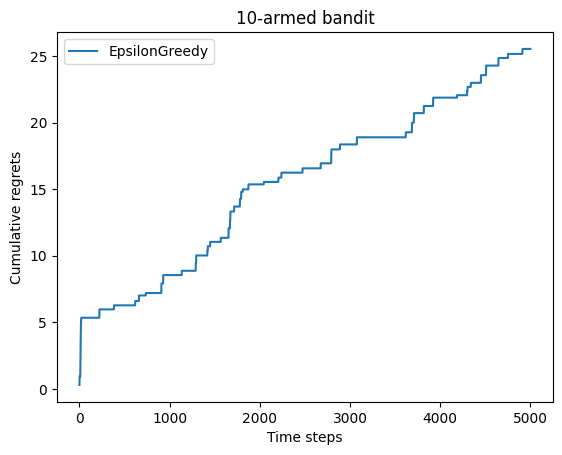

In [124]:
def plot_results(solvers, solver_names):
    """
    生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称
    """
    for idx, solver in enumerate(solvers):  ## 遍历所有的解决方案，实际上只有一个解决方案
        time_list = range(len(solver.regrets))  ## 每一步的懊悔记录，拿到横轴的数值
        plt.plot(time_list, solver.regrets, label=solver_names[idx])  # 绘制，横轴是时间步，纵轴是懊悔值
    plt.xlabel('Time steps')  ##  横轴的标签
    plt.ylabel('Cumulative regrets')  ##  纵轴的标签
    plt.title(f'{solvers[0].bandit.K}-armed bandit')  ##  标题
    plt.legend()  ##  图例
    plt.show()  ##  显示图片的


np.random.seed(1)  ## 初始化随机数的 seed 种子
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm)  ## 策略器初始化
epsilon_greedy_solver.run(5000)  ## 拉动拉杆共五千次，然后运算累加懊悔，每个杆的期望奖励等
print(f'epsilon-贪婪算法的累积懊悔为：{epsilon_greedy_solver.regret}')
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

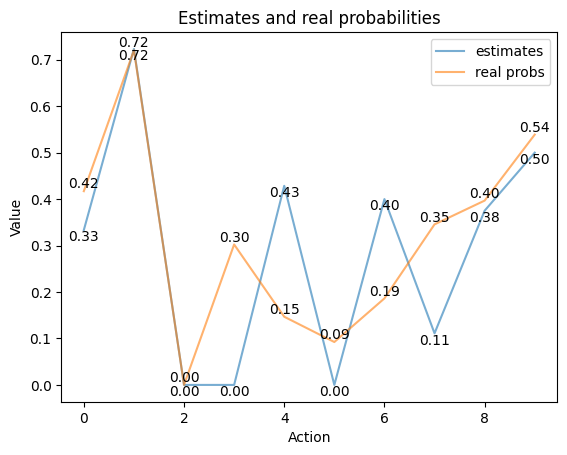

In [125]:
# 绘制概率图
def plot_estimates(bandit, solver):
    x = range(bandit.K)
    plt.plot(x, solver.estimates, alpha=0.6, label='estimates')
    plt.plot(x, bandit.probs, alpha=0.6, label='real probs')
    plt.xlabel('Action')
    plt.ylabel('Value')
    plt.title('Estimates and real probabilities')
    plt.legend()
    for i in range(bandit.K):
        plt.text(i, bandit.probs[i], f'{bandit.probs[i]:.2f}', ha='center', va='bottom')
        plt.text(i, solver.estimates[i], f'{solver.estimates[i]:.2f}', ha='center', va='top')
    plt.show()


plot_estimates(bandit_10_arm, epsilon_greedy_solver)

尝试不同的参数 $\epsilon$，并比较不同参数下的累积懊悔值。

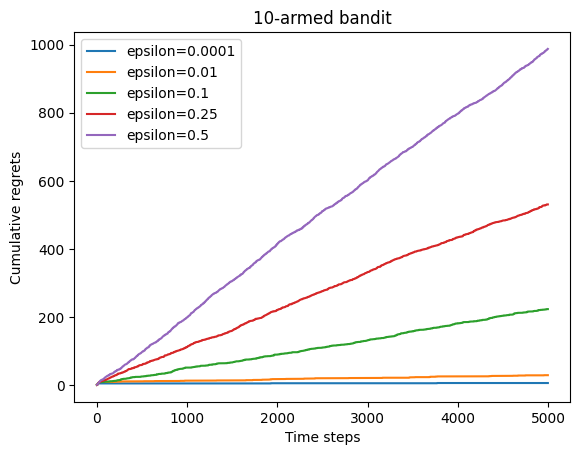

In [126]:
np.random.seed(0)  ## 给定随机种子，保证实验可以复现
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]  ## 不同的ε值
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons  ## 初始化不同的策略解决方案
]
epsilon_greedy_solver_names = [f"epsilon={e}" for e in epsilons]  ## 不同ε值对应的名称
for solver in epsilon_greedy_solver_list:  ## 遍历策略解决方案，每个策略运行五千次
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)  ## 绘制图像的

尝试$\epsilon$值随时间反比例衰减的策略，即 $\epsilon = \frac{1}{t}$。

epsilon值衰减的贪婪算法的累积懊悔为：10.114334931260183


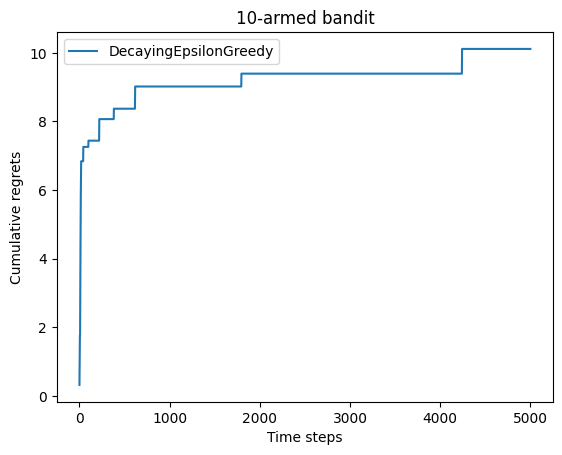

In [127]:
class DecayingEpsilonGreedy(Solver):
    """ 
    epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 
    """

    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)  ## 初始化基类Solver
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励，=1
        self.total_count = 0  ## 拉杆的总次数

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        self.total_count += 1  ## 拉杆的次数+1，此时ε=拉杆次数的倒数，拉杆次数越多ε越小
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)  ## 此时有ε的概率随机选择拉杆
        else:
            k = np.argmax(self.estimates)  ## 此时有1-ε的概率选择期望奖励最大的拉杆

        r = self.bandit.step(k)  ## 获得第k根拉杆的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新期望奖励

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)  ## 初始化延迟策略解决方案
decaying_epsilon_greedy_solver.run(5000)  ## 运行五千次拉杆操作的
print(f'epsilon值衰减的贪婪算法的累积懊悔为：{decaying_epsilon_greedy_solver.regret}')
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])  ## 绘制图像的

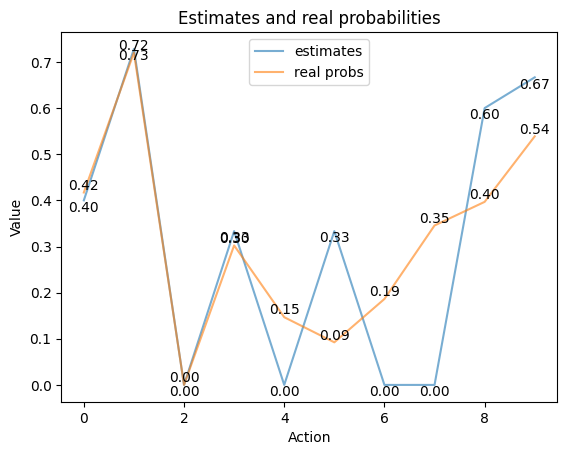

In [128]:
# 绘制概率图
plot_estimates(bandit_10_arm, decaying_epsilon_greedy_solver)

##### 2.3.2. Upper Confidence Bound (UCB)上置信界算法

霍夫丁不等式（Hoeffding's inequality）
$$
\begin{align*}
P(E(x) \geq \bar{x}_n + \epsilon) \leq e^{-2n\epsilon^2} &= p\\
\ln p &= -2n\epsilon^2\\
\epsilon &= \sqrt{\frac{-\ln p}{2n}}
\end{align*}
$$
即 $Q_t(a)$ 以$1-p$的概率 $< \hat{Q}_t(a) + \sqrt{\frac{-\ln p}{2n}}$。

令 $p = \frac{1}{t}$，则 $\epsilon = \sqrt{\frac{\ln t}{2n}}$。

为避免除数为0，为每根拉杆的尝试次数加上1，即 $\epsilon = \sqrt{\frac{\ln t}{2(n+1)}}$。

设定一个系数c来控制不确定性的比重，即 $Q_t(a) = \hat{Q}_t(a) + c\sqrt{\frac{\ln t}{2(n+1)}}$。

上置信界算法的累积懊悔为：70.45281214197854


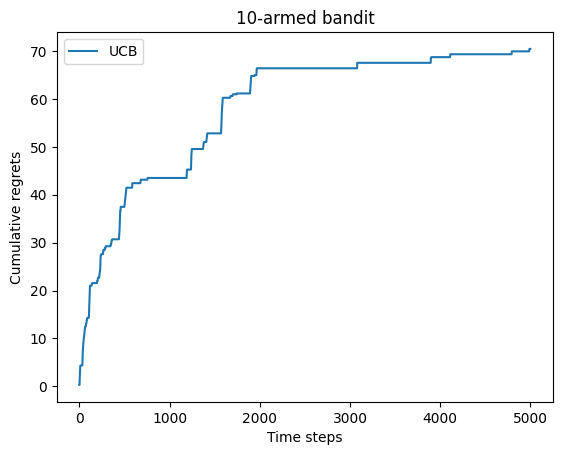

In [129]:
class UCB(Solver):
    """ 
    UCB算法,继承Solver类 
    T选π，R随机
    """

    def __init__(self, bandit, coef, init_prob=1.0):  ##  初始化ucb类的
        super().__init__(bandit)  ##  初始化基类Solver
        self.total_count = 0  ##  总的拉杆次数
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励
        self.coef = coef  ## ucb的权重

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        self.total_count += 1  ##  运行的总次数+1

        ## 算出所有拉杆的期望奖励上界
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆(期望奖励上界最大的动作)
        r = self.bandit.step(k)  ## 拿到奖励的数值
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新对应拉杆的期望奖励
        return k


np.random.seed(1)  ## 给定随机数种子，方便复现的
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)  ## 实例化ucb类的
UCB_solver.run(5000)  ## 共拉杆五千次
print(f'上置信界算法的累积懊悔为：{UCB_solver.regret}')
plot_results([UCB_solver], ["UCB"])  ## 绘制图像的

# 上置信界算法的累积懊悔为： 70.45281214197854

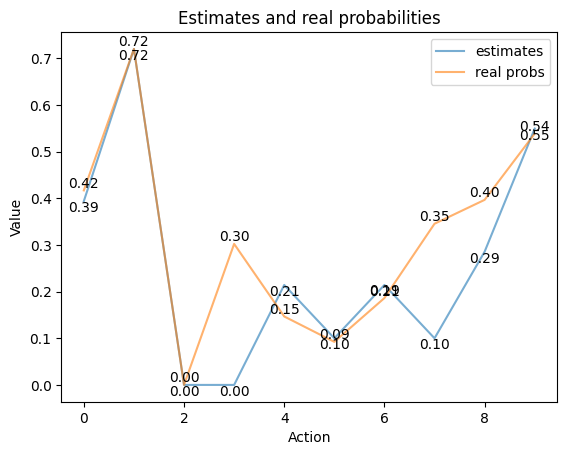

In [130]:
# 绘制概率图
plot_estimates(bandit_10_arm, UCB_solver)

##### 2.3.3. Thompson Sampling

假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。

通常用 Beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了 $k$ 次，其中$m_1$次获奖，$m_0$次未获奖，则该拉杆的奖励概率服从参数为$(m_1+1, m_0+1)$的 Beta 分布。

汤普森采样算法的累积懊悔为：57.19161964443925


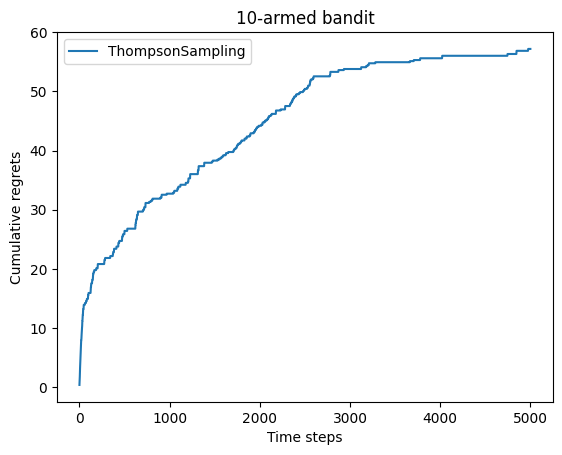

In [131]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """

    def __init__(self, bandit):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        super().run(num_steps)
        # 完成后使用Beta分布的期望值来估计每根拉杆的获奖概率
        self.estimates = self._a / (self._a + self._b)


np.random.seed(1)  ## 给定随机数种子，方便复现的
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)  ## 实例化Thompson类的
thompson_sampling_solver.run(5000)  ## 共拉杆五千次
print(f'汤普森采样算法的累积懊悔为：{thompson_sampling_solver.regret}')
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

# 汤普森采样算法的累积懊悔为：57.19161964443925

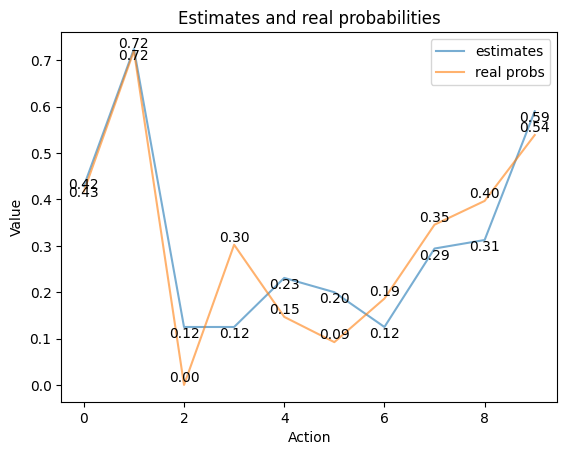

In [132]:
# 绘制概率图
plot_estimates(bandit_10_arm, thompson_sampling_solver)

### 3. 马尔可夫决策过程

> Markov decision processes are an extension of Markov chains; the difference is the addition of actions (allowing choice) and rewards (giving motivation). Conversely, if only one **a**ction exists for each state (e.g. “wait”) and all **r**ewards are the same (e.g. “zero”), a Markov decision process reduces to a Markov chain.”

#### 3.3. Utility Function

- why not finite horizon utility?

if you just go one step to go, you may go to extremely risky behaviour because you have no other chances.

- The main problem for MDPs is to optimize the agent’s behavior. To do so, **we first need to specify the criterion that we are trying to maximize in terms of accumulated rewards.**

$ U \leq \frac{R_{max}}{1-\lambda}  $

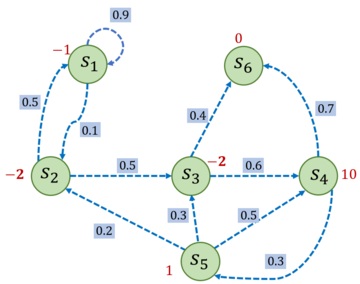

s1-s2-s3-s6

In [133]:
import numpy as np

np.random.seed(0)
# 定义状态转移概率矩阵T
T = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
T = np.array(T)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子
# chain：序列
# gamma：折扣因子
# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报
from copy import deepcopy


def compute_return(start_index, chain, gamma):
    G = 0
    ret = []
    for i in reversed(range(start_index, len(chain))):  ## 运算的方向要倒着来
        g_ = deepcopy(G)
        G = gamma * G + rewards[chain[i] - 1]  ## 从后往前依次运算求出结果
        ret.append([G, gamma, g_, rewards[chain[i] - 1], chain[i]])  ## 保存
    '''
    https://zhuanlan.zhihu.com/p/655615836
     0.0 = 0.5 *  0     +   0         6
    -2.0 = 0.5 *  0     +  -2         6->3
    -3.0 = 0.5 * -2.0   +  -2         3->2
    -2.5 = 0.5 * -3.0   +  -1         2->1
   ret=    [[ 0.0, 0.5,  0,    0, 6], 
            [-2.0, 0.5,  0.0, -2, 3], 
            [-3.0, 0.5, -2.0, -2, 2], 
            [-2.5, 0.5, -3.0, -1, 1]]
    '''
    return G


# 一个状态序列,s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print(f'根据本序列计算得到回报为：{G}')

# 根据本序列计算得到回报为：-2.5。

根据本序列计算得到回报为：-2.5


##### 3.3.2. Value Function

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

Value Function使用Bellman equation的解析解
$$
\begin{align*}
V &= R + \gamma TV \\
(I - \gamma T) V &= R \\
V &= (I - \gamma T)^{-1} R 
\end{align*}
$$

In [134]:
def compute(T, rewards, gamma, states_num):
    ''' 利用贝尔曼方程的矩阵形式计算解析解,states_num是MRP的状态数 '''
    rewards = np.array(rewards).reshape((-1, 1))  #将rewards写成列向量形式    ## r：每个状态的奖励值
    ## 对应求解析解的公式，V=(1-γP)^(-1)r
    # value = np.dot(np.linalg.inv(np.eye(states_num, states_num) - gamma * T), rewards)
    value = np.asmatrix(np.eye(states_num) - gamma * T).I @ rewards

    return value


V = compute(T, rewards, gamma, 6)
print("MRP中每个状态价值分别为\n", V)

# MRP中每个状态价值分别为
#  [[-2.01950168]
#  [-2.21451846]
#  [ 1.16142785]
#  [10.53809283]
#  [ 3.58728554]
#  [ 0.        ]]

MRP中每个状态价值分别为
 [[-2.01950168]
 [-2.21451846]
 [ 1.16142785]
 [10.53809283]
 [ 3.58728554]
 [ 0.        ]]


#### 3.4. 马尔可夫决策过程（Markov decision process，MDP）

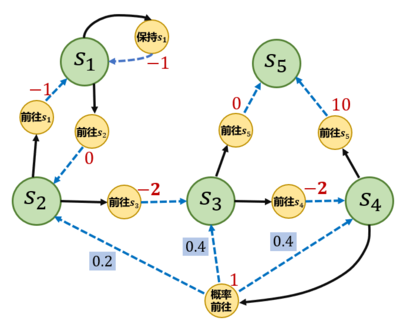

##### 3.4.2. Q-value Function 动作价值函数 action-value function

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

In [135]:
S = ["s1", "s2", "s3", "s4", "s5"]  # 状态集合
A = ["保持s1", "前往s1", "前往s2", "前往s3", "前往s4", "前往s5", "概率前往"]  # 动作集合
# 状态转移函数
T = {
    "s1-保持s1-s1": 1.0,
    "s1-前往s2-s2": 1.0,
    "s2-前往s1-s1": 1.0,
    "s2-前往s3-s3": 1.0,
    "s3-前往s4-s4": 1.0,
    "s3-前往s5-s5": 1.0,
    "s4-前往s5-s5": 1.0,
    "s4-概率前往-s2": 0.2,
    "s4-概率前往-s3": 0.4,
    "s4-概率前往-s4": 0.4,
}
# 奖励函数
R = {
    "s1-保持s1": -1,
    "s1-前往s2": 0,
    "s2-前往s1": -1,
    "s2-前往s3": -2,
    "s3-前往s4": -2,
    "s3-前往s5": 0,
    "s4-前往s5": 10,
    "s4-概率前往": 1,
}
gamma = 0.5  # 折扣因子
MDP = (S, A, T, R, gamma)

# 策略π1,随机策略
pi_1 = {
    "s1-保持s1": 0.5,
    "s1-前往s2": 0.5,
    "s2-前往s1": 0.5,
    "s2-前往s3": 0.5,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.5,
    "s4-概率前往": 0.5,
}
# 策略π2
pi_2 = {
    "s1-保持s1": 0.6,
    "s1-前往s2": 0.4,
    "s2-前往s1": 0.3,
    "s2-前往s3": 0.7,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.1,
    "s4-概率前往": 0.9,
}


# 把输入的两个字符串通过“-”连接,便于使用上述定义的T、R变量
def join(str1, str2):
    return str1 + '-' + str2

转化后的 MRP 的状态转移矩阵和奖励函数

In [136]:
gamma = 0.5
# 转化后的MRP的状态转移矩阵
T_from_mdp_to_mrp = [
    [0.5, 0.5, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.5],
    [0.0, 0.1, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.0, 0.0, 1.0],
]
'''
T(1|1) = pi_1["s1-保持s1"] * T["s1-保持s1-s1"] = 1 * 0.5 = 0.5
T(2|1) = pi_1["s1-前往s2"] * T["s1-前往s2-s2"] = 1 * 0.5 = 0.5
T(1|2) = pi_1["s2-前往s1"] * T["s2-前往s1-s1"] = 1 * 0.5 = 0.5
T(3|2) = pi_1["s2-前往s3"] * T["s2-前往s3-s3"] = 1 * 0.5 = 0.5
T(4|3) = pi_1["s3-前往s4"] * T["s3-前往s4-s4"] = 1 * 0.5 = 0.5
T(5|3) = pi_1["s3-前往s5"] * T["s3-前往s5-s5"] = 1 * 0.5 = 0.5
T(2|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s2"] = 0.5 * 0.2 = 0.1
T(3|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s3"] = 0.5 * 0.4 = 0.2
T(4|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s4"] = 0.5 * 0.4 = 0.2
T(5|4) = pi_1["s4-前往s5"] * T["s4-前往s5-s5"] = 0.5 * 1 = 0.5
T(5|5) = 1
'''
T_from_mdp_to_mrp = np.array(T_from_mdp_to_mrp)
R_from_mdp_to_mrp = [-0.5, -1.5, -1.0, 5.5, 0]  ## MDP转MRP以后的状态奖励
'''
r(s1) = pi_1["s1-保持s1"] * R["s1-保持s1"] + pi_1["s1-前往s2"] * R["s1-前往s2"] = -1 * 0.5 + 0 * 0.5 = -0.5
r(s2) = pi_1["s2-前往s1"] * R["s2-前往s1"] + pi_1["s2-前往s3"] * R["s2-前往s3"] = -1 * 0.5 + -2 * 0.5 = -1.5
r(s3) = pi_1["s3-前往s4"] * R["s3-前往s4"] + pi_1["s3-前往s5"] * R["s3-前往s5"] = -2 * 0.5 + 0 * 0.5 = -1
r(s4) = pi_1["s4-前往s5"] * R["s4-前往s5"] + pi_1["s4-概率前往"] * R["s4-概率前往"] = 10 * 0.5 + 1 * 0.5 = 5.5
r(s5) = 0
也就求出了T_from_mdp_to_mrp 奖励函数的
'''

V = compute(T_from_mdp_to_mrp, R_from_mdp_to_mrp, gamma, 5)  # 解析解
print("MDP中每个状态价值分别为\n", V)

# MDP中每个状态价值分别为
#  [[-1.22555411]
#  [-1.67666232]
#  [ 0.51890482]
#  [ 6.0756193 ]
#  [ 0.        ]]

MDP中每个状态价值分别为
 [[-1.22555411]
 [-1.67666232]
 [ 0.51890482]
 [ 6.0756193 ]
 [ 0.        ]]


#### 3.5. 蒙特卡罗方法MC

In [137]:
def sample(MDP, pi, timestep_max, number):
    ''' 采样函数,策略Pi,限制最长时间步timestep_max,总共采样序列数number '''
    S, A, T, R, gamma = MDP
    episodes = []
    for _ in range(number):
        episode = []
        timestep = 0
        s = S[np.random.randint(4)]  # 随机选择一个除s5以外的状态s作为起点
        # 当前状态为终止状态或者时间步太长时,一次采样结束
        while s != "s5" and timestep <= timestep_max:
            timestep += 1
            rand, temp = np.random.rand(), 0  ## 初始化概率，以及动作概率是0
            # 在状态s下根据策略选择动作
            for a_opt in A:  ## 遍历每个动作
                temp += pi.get(join(s, a_opt), 0)  ## 拿到状态+动作的名称，然后从策略pi_1内拿到对应的动作概率
                # fix me: 此处有bug，pi中a_opt的顺序对动作执行有影响，如：动作1动作2均为0.5，rand为0.6，始终选择动作2
                if temp > rand:  ## 该状态和动作对应的概率，满足概率条件，则执行动作action
                    a = a_opt  ## 执行动作的action，a是动作名称
                    r = R.get(join(s, a), 0)  ## 拿到状态+动作的名称，然后从状态+动作的奖励 R 内拿到对应的动作奖励
                    break  ## 已经执行了动作，退出动作的循环
            rand, temp = np.random.rand(), 0  ## 初始化概率，以及状态的概率
            # 根据状态转移概率得到下一个状态s_next
            for s_opt in S:  ## 遍历状态列表
                temp += T.get(join(join(s, a), s_opt), 0)  ## 组合了状态+动作+转移的状态名称，然后从状态+动作+转移状态的概率 T 内拿到对应的转移概率
                if temp > rand:  ##    满足概率条件，则执行状态转移
                    s_next = s_opt  ##    转移到的状态是 s_next
                    break  ##    已经转移了状态，退出状态的循环
            ## s是当前的状态，a是执行的动作，r是执行动作的奖励，s_next是执行动作以后转移到的状态
            episode.append((s, a, r, s_next))  # 把（s,a,r,s_next）元组放入序列中
            s = s_next  # s_next变成当前状态,开始接下来的循环
        episodes.append(episode)
    return episodes


# 采样5次,每个序列最长不超过1000步
episodes = sample(MDP, pi_1, 20, 5)
print('第一条序列\n', episodes[0])
print('第二条序列\n', episodes[1])
print('第五条序列\n', episodes[4])

# 第一条序列
#  [('s1', '前往s2', 0, 's2'), ('s2', '前往s3', -2, 's3'), ('s3', '前往s5', 0, 's5')]
# 第二条序列
#  [('s4', '概率前往', 1, 's4'), ('s4', '前往s5', 10, 's5')]
# 第五条序列
#  [('s2', '前往s3', -2, 's3'), ('s3', '前往s4', -2, 's4'), ('s4', '前往s5', 10, 's5')]

第一条序列
 [('s1', '前往s2', 0, 's2'), ('s2', '前往s3', -2, 's3'), ('s3', '前往s5', 0, 's5')]
第二条序列
 [('s4', '概率前往', 1, 's4'), ('s4', '前往s5', 10, 's5')]
第五条序列
 [('s2', '前往s3', -2, 's3'), ('s3', '前往s4', -2, 's4'), ('s4', '前往s5', 10, 's5')]


In [138]:
# 对所有采样序列计算所有状态的价值
def MC(episodes, V, N, gamma):
    for episode in episodes:
        G = 0
        for i in reversed(range(len(episode))):  ## 一个序列从后往前计算
            (s, a, r, s_next) = episode[i]  # 从序列中取出一个元组（s,a,r,s_next）
            G = r + gamma * G  # 计算折扣累计奖励
            N[s] += 1  # 记录状态s出现的次数
            # 计算状态s的价值，每次更新时只改变当前状态的价值
            V[s] += (G - V[s]) / N[s]


timestep_max = 20
# 采样1000次,可以自行修改
episodes = sample(MDP, pi_1, timestep_max, 10000)
gamma = 0.5
V = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
N = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
MC(episodes, V, N, gamma)
print("使用蒙特卡洛方法计算MDP的状态价值为\n", V)

# 使用蒙特卡洛方法计算MDP的状态价值为
#  {'s1': -1.228923788722258, 's2': -1.6955696284402704, 's3': 0.4823809701532294,
# 's4': 5.967514743019431, 's5': 0}

使用蒙特卡洛方法计算MDP的状态价值为
 {'s1': -1.2206481669904494, 's2': -1.6886433026750503, 's3': 0.49346512992377956, 's4': 6.037788973046783, 's5': 0}


#### 3.6. 占用度量

In [139]:
def occupancy(episodes, s, a, timestep_max, gamma):
    ''' 计算状态动作对（s,a）出现的频率,以此来估算策略的占用度量 '''
    rho = 0  # 初始化占用度量
    total_times = np.zeros(timestep_max)  # 初始化每个时间步t各被经历过几次
    occur_times = np.zeros(timestep_max)  # 初始化(s_t,a_t)=(s,a)的次数
    for episode in episodes:  ## 遍历每个采样的内容
        for i in range(len(episode)):  ## 遍历每个采样内部的状态、动作的内容
            (s_opt, a_opt, r, s_next) = episode[i]  ## 拿到每个采样内的 状态、动作、动作的奖励、下一个状态
            total_times[i] += 1  ## 统计序列所在index的次数（时间步t各被经历过几次）
            if s == s_opt and a == a_opt:  ## 状态、动作和给定的相同
                occur_times[i] += 1  ## 也就是（状态，动作）对的次数+1
    # for i in reversed(range(timestep_max)):  ## 逆序算占用度量
    # fix me：不需要逆序？
    for i in range(timestep_max):
        if total_times[i]:  ## 序列所在的index有值
            rho += gamma ** i * occur_times[i] / total_times[i]  ## 按照公式运算
    return (1 - gamma) * rho


gamma = 0.5  #折扣因子
timestep_max = 1000  #最大时间步长

episodes_1 = sample(MDP, pi_1, timestep_max, 1000)  ## 采样，参数是MDP，pi_1是策略，timestep_max是最长时间步，10000是采样的次数
episodes_2 = sample(MDP, pi_2, timestep_max, 1000)  ## 和上面只有策略不同，pi_2
rho_1 = occupancy(episodes_1, "s4", "概率前往", timestep_max, gamma)  ## 算占用度量
rho_2 = occupancy(episodes_2, "s4", "概率前往", timestep_max, gamma)
print(rho_1, rho_2)

# 0.112567796310472 0.23199480615618912

0.117927768265181 0.23436384017172737


### 4. 动态规划算法

#### 4.1. 简介

基于动态规划的强化学习算法主要有两种：一是**策略迭代（policy iteration）**，二是**价值迭代（value iteration）**。

只适用于有限马尔可夫决策过程，即状态空间和动作空间是离散且有限的。

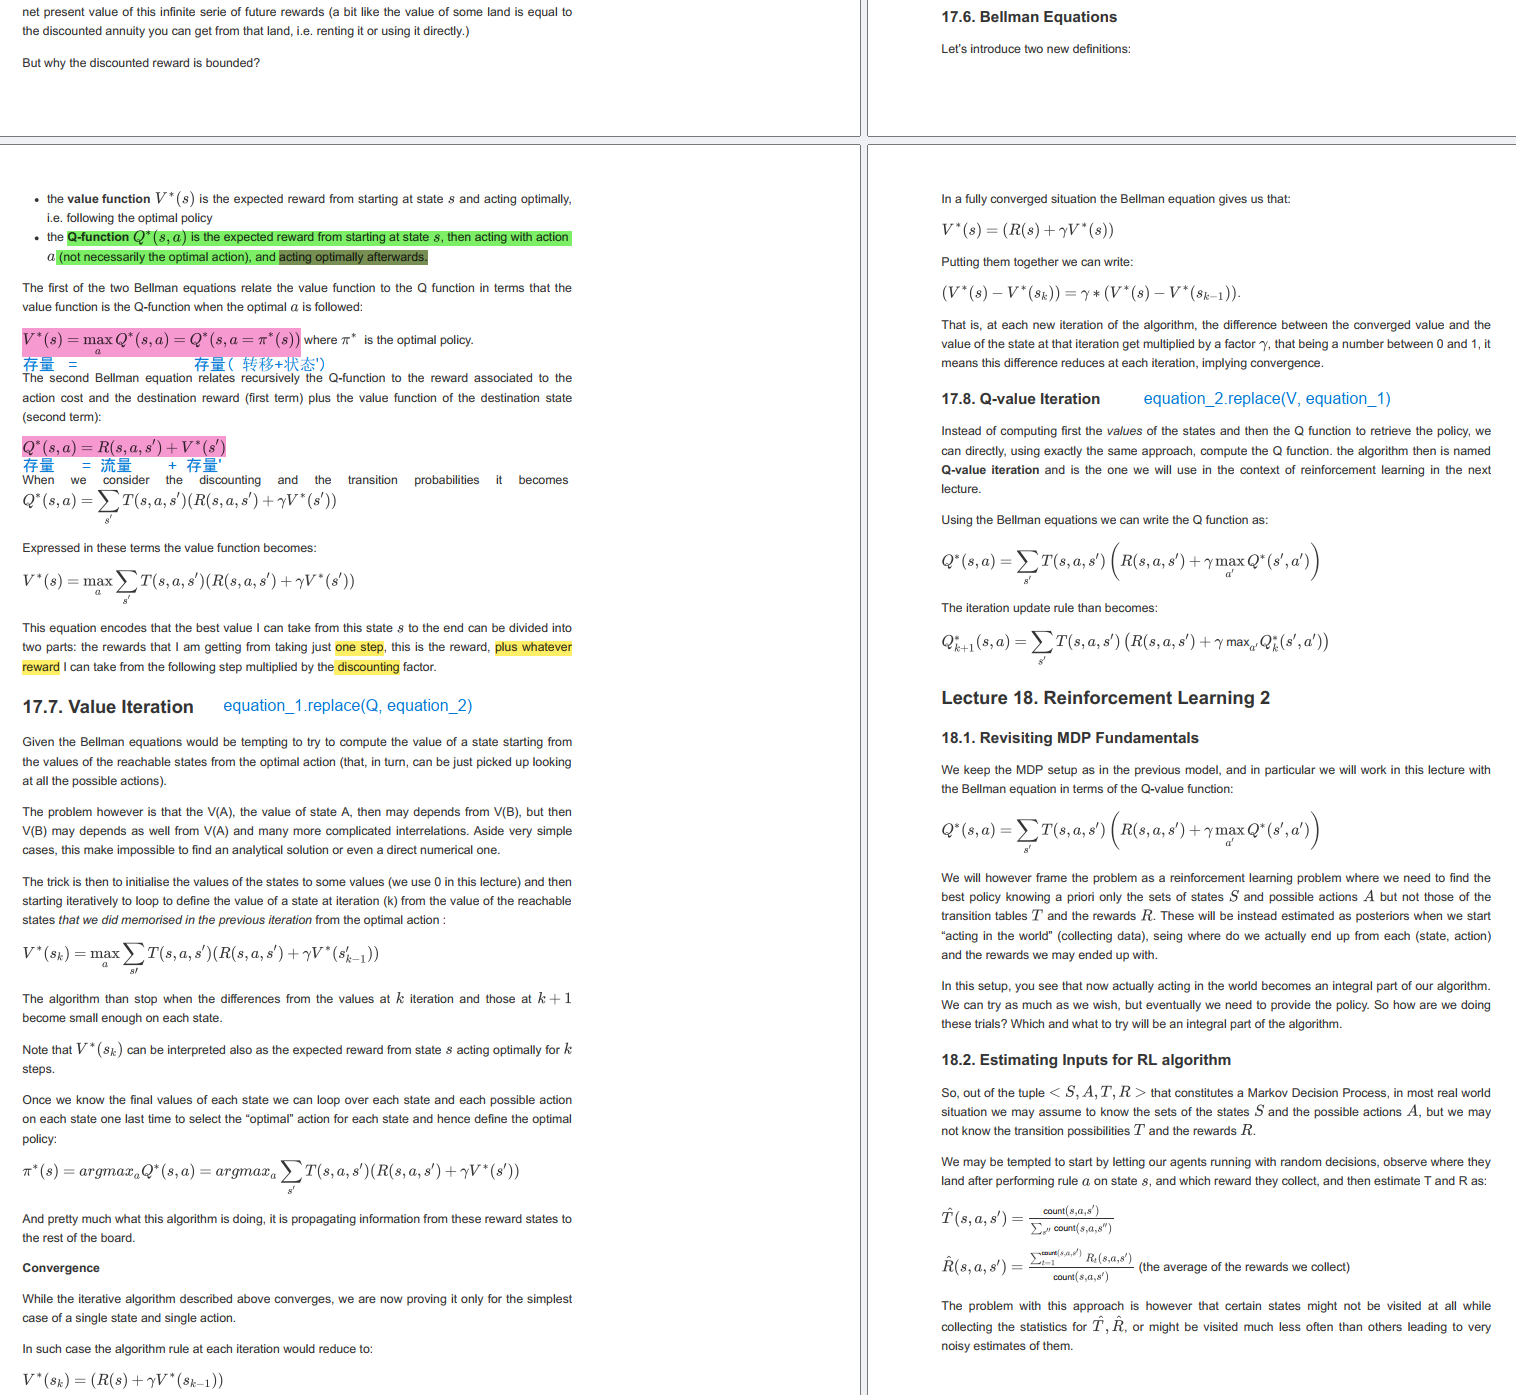

#### 4.2. 悬崖漫步环境

| 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 |
|---|---|---|---|---|---|---|---|---|---|---|---|
| 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 |
| 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 32 | 33 | 34 | 35 |
| 36 | 37 | 38 | 39 | 40 | 41 | 42 | 43 | 44 | 45 | 46 | 47 |

In [140]:
import copy


class CliffWalkingEnv:
    """ 悬崖漫步环境"""

    def __init__(self, ncol=12, nrow=4):
        self.ncol = ncol  # 定义网格世界的列
        self.nrow = nrow  # 定义网格世界的行
        # 转移矩阵T[state][action] = [(p, next_state, reward, done)]包含下一个状态和奖励
        self.T = self.createT()

    def createT(self):
        # 初始化
        T = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]  # 48*4
        # 4种动作, change[0]:上,change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for r in range(self.nrow):
            for c in range(self.ncol):
                s = self.state(r, c)  ##  当前状态
                for a in range(4):
                    #   位置在悬崖或者目标状态,因为无法继续交互,任何动作奖励都为0
                    ##  最后一行是悬崖的，处在悬崖是不可能的，所以可以任意初始化 
                    if r == self.nrow - 1 and c > 0:
                        T[s][a] = [(1, s, 0, True)]
                        continue
                    # 其他位置
                    ## 其他地方的下个状态，或者说下个x坐标，都要满足在格子内部，若是可能移动到网格的外部，下一步就保持不动
                    c_ = min(self.ncol - 1, max(0, c + change[a][0]))  # 限制在0~11之间
                    r_ = min(self.nrow - 1, max(0, r + change[a][1]))  # 限制在0~3之间
                    s_ = self.state(r_, c_)  ##  下个状态的数组地址
                    reward = -1  ## 奖励值初始化到 -1
                    done = False  ##  默认没有达到终止条件（下个坐标在悬崖，或者在终点）
                    # 下一个位置在悬崖或者终点
                    if r_ == self.nrow - 1 and c_ > 0:  ## 最后一行是悬崖的
                        if c_ != self.ncol - 1:  # 下一个位置在悬崖
                            reward = -100  ## 下个坐标是悬崖，奖励是-100
                        done = True  ## 达到了终止条件
                    ##  对给定的动作a，下一步的转移到s_概率是1，reward是动作奖励，done表示是否终止
                    T[s][a] = [(1, s_, reward, done)]
        # print(f'T:{T}')
        return T

    def state(self, row, col):
        return row * self.ncol + col

#### 4.3. 策略迭代算法（Value Iteration）

- the **value function $V^*(s)$** is the expected reward from starting at state $s$ and acting optimally, i.e., following the optimal policy.
$$
\begin{align*}
V^*(s) &= \max_{a} Q^*(s, a) = Q^*(s, a=\pi^*(s))\\
&= \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- the **Q-function $Q^*(s, a)$** is the expected reward from starting at state $s$, then acting wih action $a$(not necessarily the optimal action), and acting optimally afterwards.
$$
\begin{align*}
Q^*(s, a) &= R(s, a, s') + V^*(s')\\
&= \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
\end{align*}
$$
- **Value Iteration**
$$
V^*(s_k) = \max_{a} \sum_{s'} T(s_k, a, s') [R(s_k, a, s') + \gamma V^*(s'_{k-1})]\\
\pi^*(s) = \operatorname{argmax}_{a} Q^*(s, a) = \operatorname{argmax}_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma V^*(s')]
$$
- **Q-value Iteration**
$$
Q^*(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*(s', a')]\\
Q^*_{k+1}(s,a) = \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \max_{a'} Q^*_k(s', a')]
$$
- **Q-value Iteration by sampling**
- - Estimating directly the $Q(s,a)$ we don't need to estimate firstly the T or R matrices.
$$
Q^*(s,a) = \frac{1}{k}\sum_{i=1}^{k}Q^*_i(s,a) = \frac{1}{k}\sum_{i=1}^{k}(R(s,a,{s_i}')+\gamma\max_{a'}Q^*({s_i}',a'))
$$

In [141]:
class BaseIteration:
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 策略评估收敛阈值
        self.gamma = gamma  # 折扣因子
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]

    def policy_improvement(self):
        '''
        策略提升：基于v，更新pi
        '''
        for s in range(self.env.nrow * self.env.ncol):  ##  遍历所有的状态
            qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
            for a in range(4):  ##  遍历所有的动作，上下左右这几个方向
                qsa = 0  ##  动作价值初始化到0
                ## 遍历（s,a）对应的s转移可能，拿到T（s,a,s'）、s'、动作的奖励r、是否终止的
                ## 此处对应的self.env.T[s][a]的长度都是1（1个4元组），也就是执行某个动作以后，该动作只能转移到某个确定的状态，不能按T转移到多个状态
                for res in self.env.T[s][a]:
                    p, s_, r, done = res  ## 状态转移概率此处=1、下个状态、动作的奖励r(该循环内不变)、是否终止的
                    qsa += p * (r + self.gamma * self.v[s_] * (1 - done))
                qsa_list.append(qsa)  ## 和策略评估相比较，少了状态动作选择的概率也就是没有策略了，此时选择每个动作的概率都是1
            # 可能多个动作价值Q(s,a)并列第一，第一均分概率，其他动作概率为0
            maxq = max(qsa_list)  ## 拿到这几个动作内最大的价值
            cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
        print("策略提升完成")
        return self.pi

In [142]:
class PolicyIteration(BaseIteration):
    """ 策略迭代算法 Q-value Iteration """
    def __init__(self, env, theta, gamma):
        super().__init__(env, theta, gamma)
        self.pi = [[0.25, 0.25, 0.25, 0.25] for i in range(self.env.ncol * self.env.nrow)]  # 初始化为均匀随机策略  

    def policy_evaluation(self):
        '''
        策略评估Q_value evaluation：基于v、pi，计算状态价值函数v
        '''
        cnt = 0  # 计数器
        max_diff = self.theta + 1
        while max_diff > self.theta:  ## 不断循环，直到old价值函数和new价值函数的绝对值差值很小了，< 给定的很小值 self.theta
            max_diff = 0
            v_ = [0] * self.env.ncol * self.env.nrow  ##  状态价值函数的列表
            for s in range(self.env.ncol * self.env.nrow):  ##  遍历所有的状态
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):  ##  遍历所有的动作，上下左右这几个方向
                    qsa = 0  ##  动作价值初始化到0
                    ## 遍历（s,a）对应的s转移可能，拿到T（s,a,s'）、s'、动作的奖励r、是否终止的
                    ## 此处对应的self.env.T[s][a]的长度都是1（1个4元组），也就是执行某个动作以后，该动作只能转移到某个确定的状态，不能按T转移到多个状态
                    for res in self.env.T[s][a]:
                        p, s_, r, done = res  ## 状态转移概率此处=1、下个状态、动作的奖励r(该循环内不变)、是否终止的
                        qsa += p * (r + self.gamma * self.v[s_] * (1 - done))  # 奖励和下一个状态有关,所以需要和状态转移概率相乘
                    qsa_list.append(self.pi[s][a] * qsa)  ##  还有一个选择动作的可能性 self.pi，每个动作的pi，对应公式贝尔曼期望方程最开始的累加部分
                ##  累加动作价值，得到状态价值，赋值到 new 价值函数的，也就是贝尔曼期望方程最开始的累加部分
                v_[s] = sum(qsa_list)  # 状态价值函数和动作价值函数之间的关系
                max_diff = max(max_diff, abs(v_[s] - self.v[s]))  ##  old价值函数和new价值函数的绝对值差值
            self.v = v_  ##  复制new价值函数给old价值函数
            cnt += 1
        print(f'策略评估进行{cnt}轮后完成')

    def policy_iteration(self):  # 策略迭代
        while True:
            self.policy_evaluation()  ## 策略评估函数
            old_pi = copy.deepcopy(self.pi)  # 将列表进行深拷贝,方便接下来进行比较
            new_pi = self.policy_improvement()  ##  策略提升函数
            if old_pi == new_pi: break  ##  策略不变了就可以停止迭代

In [143]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    for r in range(agent.env.nrow):
        for c in range(agent.env.ncol):
            s = agent.env.state(r, c)
            # 为了输出美观,保持输出6个字符
            print(f'{agent.v[s]:6.3f}', end=' ')
        print()

    print("策略：")
    for r in range(agent.env.nrow):
        for c in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            s = agent.env.state(r, c)
            if s in disaster:
                print('****', end=' ')
            elif s in end:  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.pi[s]
                pi_str = ''
                for i, v in enumerate(action_meaning):
                    pi_str += v if a[i] > 0 else 'o'
                print(pi_str, end=' ')
        print()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 策略评估进行60轮后完成
# 策略提升完成
# 策略评估进行72轮后完成
# 策略提升完成
# 策略评估进行44轮后完成
# 策略提升完成
# 策略评估进行12轮后完成
# 策略提升完成
# 策略评估进行1轮后完成
# 策略提升完成
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

策略评估进行60轮后完成
策略提升完成
策略评估进行72轮后完成
策略提升完成
策略评估进行44轮后完成
策略提升完成
策略评估进行12轮后完成
策略提升完成
策略评估进行1轮后完成
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


#### 4.4. 价值迭代算法

In [144]:
class ValueIteration(BaseIteration):
    """ 价值迭代算法 Value Iteration"""
    def value_evaluation(self):
        '''
        价值迭代：基于v、最佳a，更新v
        '''
        cnt = 0
        max_diff = self.theta + 1
        while max_diff > self.theta:
            max_diff = 0
            v_ = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []
                for a in range(4):
                    qsa = 0
                    for res in self.env.T[s][a]:
                        p, s_, r, done = res
                        qsa += p * (r + self.gamma * self.v[s_] * (1 - done))
                    ## 和策略评估相比较，少了状态动作选择的概率也就是没有策略了，此时选择每个动作的概率都是1
                    qsa_list.append(qsa)  # 这一行和下一行代码是价值迭代和策略迭代的主要区别
                v_[s] = max(qsa_list)  ## 拿到这几个动作内最大的价值
                max_diff = max(max_diff, abs(v_[s] - self.v[s]))
            self.v = v_
            if max_diff < self.theta: break
            cnt += 1
        print(f'价值迭代一共进行{cnt}轮')

    def value_iteration(self):
        self.value_evaluation()
        self.policy_improvement()


env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 价值迭代一共进行14轮
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

价值迭代一共进行14轮
策略提升完成
状态价值：
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 
-7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 
-7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 
-7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 
策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
